<a href="https://colab.research.google.com/github/Aditya148/zocket/blob/main/Zocket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U google-generativeai langgraph httpx langchain-google-genai
!pip install einops timm flash_attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.3/717.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 965.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.4 MB/s eta 0:00:00
  Preparing metadata (setup.

In [2]:
# Standard library imports first, alphabetical order
import copy
import random
import time

from IPython.display import display
from IPython.display import Markdown
import textwrap

# Related third-party libraries grouped together
from typing import Dict, TypedDict, Optional
from langgraph.graph import StateGraph, END

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
import requests

# Hugging Face Transformers last
from transformers import AutoProcessor, AutoModelForCausalLM
# This import is a duplicate and should be removed: from transformers import AutoModelForCausalLM

import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata

#Gemini Models for Analyzing the Image Captions/Descriptions

In [3]:
def to_markdown(text):
  text = text.replace('•', ' *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

gemini_model = ChatGoogleGenerativeAI(model="gemini-pro",google_api_key=GOOGLE_API_KEY)
def llm(x):
    return gemini_model.invoke(x).content
%matplotlib inline

In [4]:
model = genai.GenerativeModel('gemini-1.5-pro')

# Display formatted Markdown response
response = model.generate_content("Calculate the sum of all prime numbers between 0 and 20.")
to_markdown(response.text)

> Here's how to calculate the sum of prime numbers between 0 and 20:
> 
> **1. Identify the Prime Numbers:**
> 
>    Prime numbers between 0 and 20 are: 2, 3, 5, 7, 11, 13, 17, 19
> 
> **2. Calculate the Sum:**
> 
>    2 + 3 + 5 + 7 + 11 + 13 + 17 + 19 = **77**
> 
> **Therefore, the sum of all prime numbers between 0 and 20 is 77.** 


#Utility Method for Getting Captions - Using Florence-2-Large

In [5]:
def get_caption(image, task_prompt, text_input=None):
    model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)
    processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

#Utility Methods for Plotting Boxes

In [ ]:
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

In [ ]:
def draw_ocr_bboxes(image, prediction):
    scale = 1
    # Define colormap
    colormap = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)
    display(image)

##Loading Images

In [6]:
url1 = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
url2 = "https://static.startuptalky.com/2022/02/cost-effective-innovative-ad-Campaign-StartupTalky.jpg"
image1 = Image.open(requests.get(url1, stream=True).raw)
image2 = Image.open(requests.get(url2, stream=True).raw)

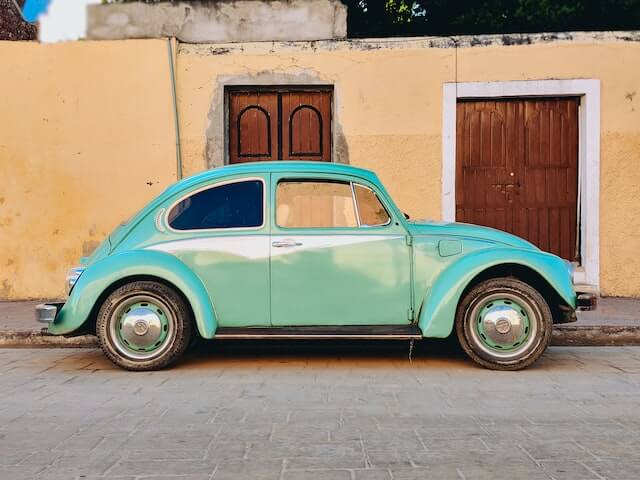

In [7]:
image1

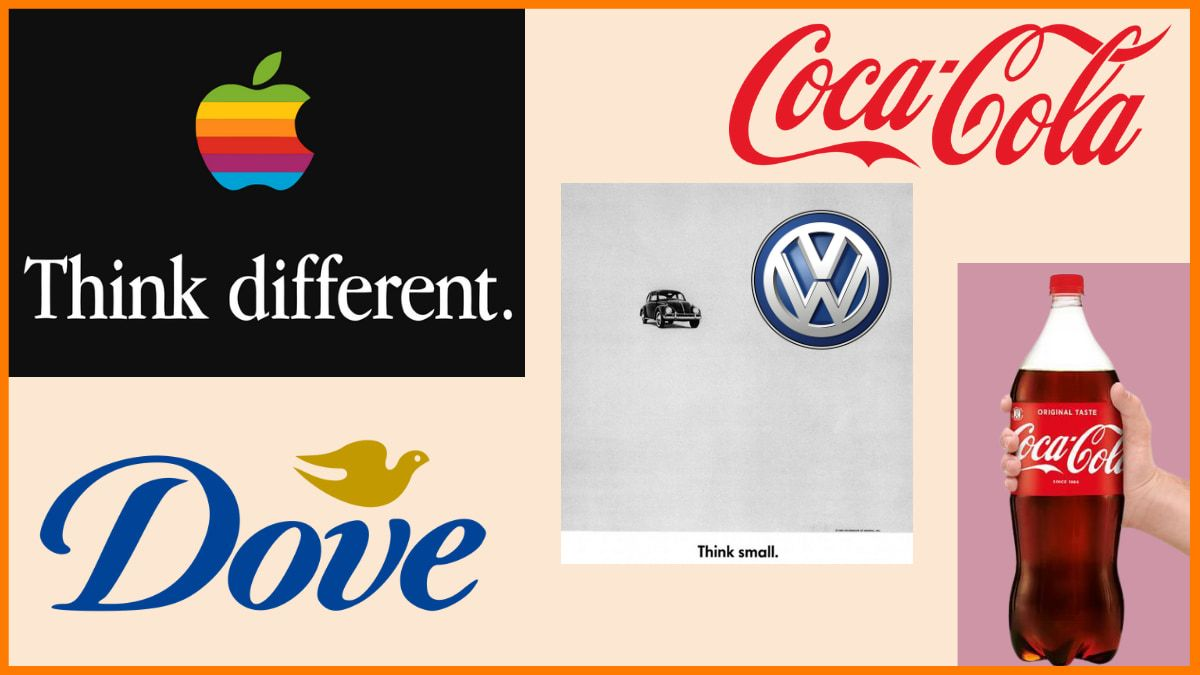

In [8]:
image2

##Getting Detailed Caption/Description of both the images

In [16]:
task_prompt = '<MORE_DETAILED_CAPTION>'
output_text1 = get_caption(image1, task_prompt)
output_text2 = get_caption(image2, task_prompt)

In [17]:
print(output_text1)
print(output_text2)

{'<MORE_DETAILED_CAPTION>': 'The image is a collage of four different logos of different brands - Apple, Dove, and Coca-Cola. \n\nThe first logo on the top left is a black square with the Apple logo in the center and the words "Think different." Below the logo, there is a text that reads "Apple" in white letters. The second logo is a rainbow-colored apple with the word "Dove" written in blue letters.\n\nIn the center of the image, there are two smaller logos - one is a Volkswagen logo and the other is a hand holding a bottle of Coca Cola. The third logo is an illustration of a car with the Volkswagen logo on it. The fourth logo is the Dove logo, which is a blue bird with a yellow beak. The text "Think small."\n\nAll four logos are arranged in a square formation on a white background.'}


##Getting Objects in the Images

{'<OD>': {'bboxes': [[34.23999786376953, 160.0800018310547, 597.4400024414062, 371.7599792480469], [456.0, 97.68000030517578, 580.1599731445312, 261.8399963378906], [450.8800048828125, 276.7200012207031, 554.5599975585938, 370.79998779296875], [95.68000030517578, 280.55999755859375, 198.72000122070312, 371.2799987792969]], 'labels': ['car', 'door', 'wheel', 'wheel']}}


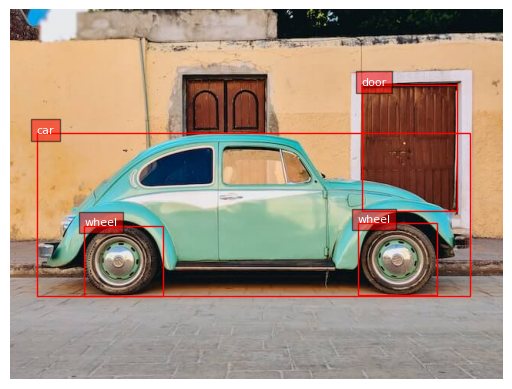

In [ ]:
### Object Detection ###
task_prompt = '<OD>'
od_result1 = get_caption(image1, task_prompt)
print(od_result1)
plot_bbox(image1, od_result1['<OD>'])

{'<OD>': {'bboxes': [[34.23999786376953, 160.0800018310547, 597.4400024414062, 371.7599792480469], [456.0, 97.68000030517578, 580.1599731445312, 261.8399963378906], [450.8800048828125, 276.7200012207031, 554.5599975585938, 370.79998779296875], [95.68000030517578, 280.55999755859375, 198.72000122070312, 371.2799987792969]], 'labels': ['car', 'door', 'wheel', 'wheel']}}


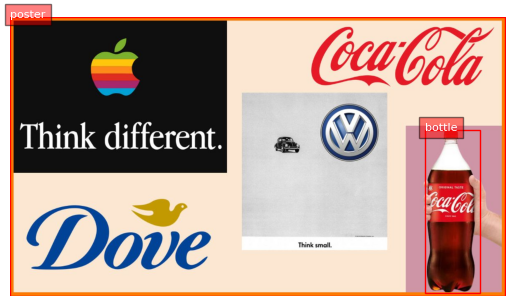

In [ ]:
### Object Detection ###
task_prompt = '<OD>'
od_result2 = get_caption(image2, task_prompt)
print(od_result1)
plot_bbox(image2, od_result2['<OD>'])

##Reading Characters in the Images using OCR

In [ ]:
### OCR Detection ###
task_prompt = '<OCR>'
ocr_result1 = get_caption(image1, task_prompt)
print(ocr_result1)
# draw_ocr_bboxes(image1, ocr_result1['<OCR>'])

{'<OCR>': '٠٠'}


In [ ]:
### OCR Detection ###
task_prompt = '<OCR>'
ocr_result2 = get_caption(image2, task_prompt)
print(ocr_result2)
# draw_ocr_bboxes(image1, ocr_result2['<OCR>'])

{'<OCR>': 'Coca-ColaThink different.ORIGINAL TASTEoca ColDoveThink small.'}


##Getting characters alongwith the bounding boxes in the Images

{'quad_boxes': [], 'labels': []}


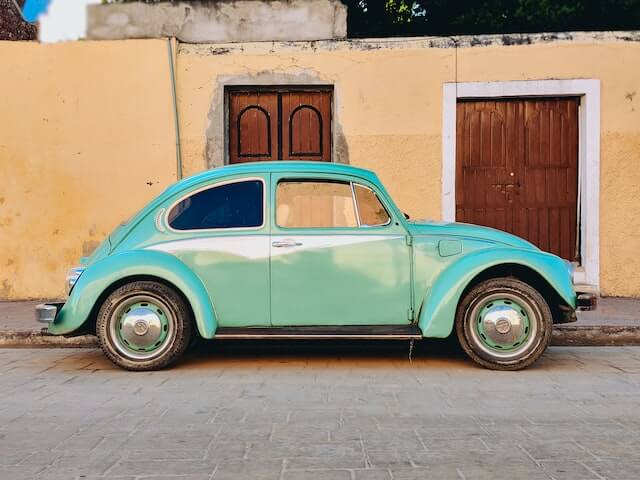

In [ ]:
### OCR For the given Image ###
task_prompt = '<OCR_WITH_REGION>'
ocr_with_region_result1 = get_caption(image1, task_prompt)
print(ocr_with_region_result1['<OCR_WITH_REGION>'])
draw_ocr_bboxes(image1, ocr_with_region_result1['<OCR_WITH_REGION>'])
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

{'quad_boxes': [[732.6000366210938, 15.1875, 1164.60009765625, 15.1875, 1164.60009765625, 172.46250915527344, 732.6000366210938, 172.46250915527344], [22.200000762939453, 250.7624969482422, 510.6000061035156, 250.7624969482422, 510.6000061035156, 325.6875, 22.200000762939453, 325.6875], [45.0, 444.4875183105469, 489.0000305175781, 463.38751220703125, 485.4000244140625, 618.6375122070312, 45.0, 614.5875244140625], [1014.6000366210938, 420.1875, 1125.0, 424.2375183105469, 1123.800048828125, 478.2375183105469, 1012.2000122070312, 474.1875]], 'labels': ['</s>Coca-Cola', 'Think different.', 'Dove', 'Coca Col']}


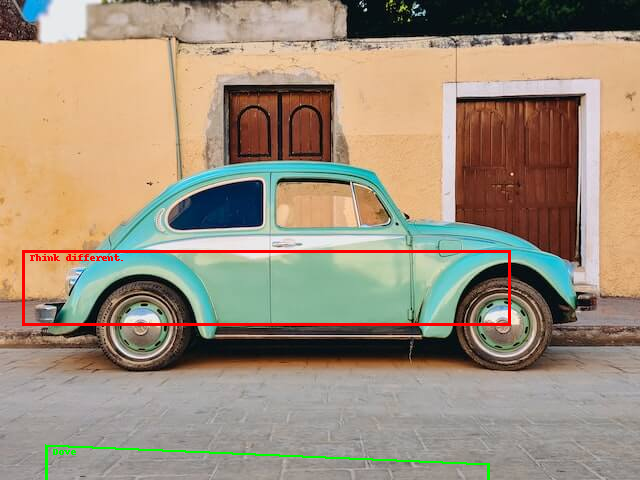

In [ ]:
### OCR For the given Image ###
task_prompt = '<OCR_WITH_REGION>'
ocr_with_region_result2 = get_caption(image2, task_prompt)
print(ocr_with_region_result2['<OCR_WITH_REGION>'])
draw_ocr_bboxes(image1, ocr_with_region_result2['<OCR_WITH_REGION>'])
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

In [ ]:
# import copy
# import random
# output_image = copy.deepcopy(image)
# draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'])

##Generating Metadata for analysis purpose

In [11]:
# Can play around to see better results
def get_metadata(output_text):
    # metadata = {
    #     'image_caption': output_text,
    #     'objects_present_in_image': od_result['<OD>']['labels'],
    #     'text_data_in_image': ocr_result['<OCR>'],
    # }
    return output_text

In [18]:
metadata1 = get_metadata(output_text1)
metadata2 = get_metadata(output_text2)

In [13]:
metadata1['<MORE_DETAILED_CAPTION>']

'The image shows a vintage Volkswagen Beetle car parked on a cobblestone street in front of a yellow building with two wooden doors. The car is painted in a bright turquoise color and has a white stripe running along the side. It has two doors on either side of the car, one on top of the other, and a small window on the front. The building appears to be old and dilapidated, with peeling paint and crumbling walls. The sky is blue and there are trees in the background.'

In [19]:
metadata2['<MORE_DETAILED_CAPTION>']

'The image is a collage of four different logos of different brands - Apple, Dove, and Coca-Cola. \n\nThe first logo on the top left is a black square with the Apple logo in the center and the words "Think different." Below the logo, there is a text that reads "Apple" in white letters. The second logo is a rainbow-colored apple with the word "Dove" written in blue letters.\n\nIn the center of the image, there are two smaller logos - one is a Volkswagen logo and the other is a hand holding a bottle of Coca Cola. The third logo is an illustration of a car with the Volkswagen logo on it. The fourth logo is the Dove logo, which is a blue bird with a yellow beak. The text "Think small."\n\nAll four logos are arranged in a square formation on a white background.'

##Method to analyze the Caption or Metadata of the Images

In [20]:
def analyze_caption(caption):
  response = model.generate_content("Is the following image caption describing an ad campaign? Answer it in Yes or No\n\n" + caption)
  return response

##Response for the first Image

In [15]:
metadata = metadata1['<MORE_DETAILED_CAPTION>']
response1 = analyze_caption(metadata)
to_markdown(response1.text)

> No 


##Response for the second Image

In [21]:
metadata = metadata2['<MORE_DETAILED_CAPTION>']
response2 = analyze_caption(metadata)
to_markdown(response2.text)

> Yes 


#Streamlit Application for the above Ad-Campaign Recognition

In [ ]:
import os
import streamlit as st
from PIL import Image

from transformers import AutoProcessor, AutoModelForCausalLM

from IPython.display import display
from IPython.display import Markdown
import textwrap

import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI

os.environ['HUGGINGFACE_API_KEY'] = ''
os.environ['GOOGLE_API_KEY'] = ''

@st.cache_resource
def load_model():
    model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)
    processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)
    return processor, model

def get_caption(image, task_prompt, processor, model, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

def analyze_captions(caption):
    def to_markdown(text):
        text = text.replace('•', ' *')
        return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))
    model = genai.GenerativeModel('gemini-1.5-pro')
    response = model.generate_content("Is the following image caption describing an ad campaign? Answer it in Yes or No\n\n" + caption)
    return to_markdown(response.text)

# Streamlit app
def main():
    st.title("Image Caption Generator using CLIP")
    st.write("Upload an image (PNG or JPEG) to generate a caption.")

    # Upload image
    uploaded_file = st.file_uploader("Choose an image...", type=["png", "jpeg", "jpg"])

    if uploaded_file is not None:
        # Display uploaded image
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded Image", use_column_width=True)

        # Load model and processor
        processor, model = load_model()

        # Generate and display caption
        caption = get_caption(image, '<MORE_DETAILED_CAPTION>', processor, model)
        result = analyze_caption(caption)
        st.write("Generated Caption:")
        st.write(caption)

if __name__ == "__main__":
    main()
